# <center>Прогнозирование **S&P100** на своих предыдущих значениях и курсов входящих в него акций

In [1]:
# import os
# os.chdir("..")

# %load_ext autoreload
# %autoreload 2

# from dotenv import load_dotenv
# load_dotenv()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS/project1_sp100')

In [4]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [6]:
tf.random.set_seed(17)

#### Данные
загрузим ранее подготовленный датасет

In [7]:
path_to_data = "data"

In [8]:
features = pd.read_csv(os.path.join(path_to_data, "sp100.csv"), index_col=0)

In [9]:
features.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,AXP,BA,BAC,BIIB,BK,BKNG,BLK,BMY,BRK.B,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DD,DHR,DIS,DOW,DUK,EMR,EXC,F,FB,...,MDLZ,MDT,MET,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NVDA,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RTX,SBUX,SLB,SO,SPG,T,TGT,TMO,TXN,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM,S&P100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-18,0.928013,35.119999,15.150405,15.17,16.000000,1445.000000,24.0625,69.0625,38.4375,64.1250,44.220886,45.0000,24.000000,35.687500,39.617340,355.125,18.000,62.162937,34.000000,438.750000,24.96875,35.0,31.50000,16.166666,42.500,16.937721,51.250,4.3,56.00000,18.000000,44.65625,61.823280,8.363343,34.034248,49.799999,46.687752,30.09375,18.84375,29.812790,38.23,...,31.25,44.3750,13.814617,48.56250,23.000000,70.8125,66.87500,57.65625,21.1875,1.196429,6.328125,3.817708,27.81250,10.538675,36.2500,36.500000,58.46875,49.389999,36.709999,69.53125,19.745123,3.257813,33.06250,14.279787,23.029551,41.1250,34.00000,14.4375,55.187500,7.375000,11.093750,68.6875,23.4375,14.125,52.835213,29.2500,19.4375,65.5625,42.37500,795.679993
2000-01-19,0.951451,35.119999,14.841785,15.17,15.781250,1416.666626,23.5625,72.0000,39.0000,66.8125,43.454998,47.6250,24.000000,40.333332,39.352341,374.625,18.250,60.973213,34.180000,448.125000,24.65625,35.0,30.75000,17.145834,43.375,16.794786,51.875,4.3,56.15625,17.906250,43.96875,61.289555,8.268575,34.280876,49.799999,47.995228,30.84375,19.18750,29.366285,38.23,...,31.25,44.9375,13.814617,49.40625,23.375000,71.5000,67.84375,53.50000,21.6875,1.196429,6.601563,3.781250,28.56250,10.688373,36.4375,37.000000,57.68750,49.389999,36.709999,73.31250,19.096130,3.187500,32.93750,14.623419,23.145567,40.5625,34.96875,14.2500,54.750000,7.437500,10.906250,68.2500,23.0000,14.125,51.823475,30.1875,18.3750,64.0625,42.78125,790.309998
2000-01-20,1.013393,35.119999,14.392884,15.17,15.953125,1404.583374,23.7500,71.8125,40.5000,64.7500,44.175297,46.5000,23.539063,40.895832,38.954845,371.625,17.500,58.891201,34.000000,439.570313,23.56250,35.0,30.96875,16.625000,42.375,16.318338,50.000,4.3,56.18750,16.859375,43.75000,59.680962,8.090883,33.171062,49.799999,48.648964,30.21875,18.90625,28.696527,38.23,...,31.25,44.0000,13.814617,47.56250,22.578125,72.9375,67.40625,53.00000,21.4375,1.196429,6.445313,3.770833,29.62500,10.598555,36.1250,36.390625,56.28125,49.389999,36.709999,77.81250,18.663467,3.132813,32.28125,14.547056,23.261585,41.0000,33.84375,14.5000,56.437500,7.625000,10.500000,68.8750,22.1875,14.125,51.992096,30.1875,18.1875,63.3750,41.84375,783.330017
2000-01-21,0.993862,35.119999,14.000096,15.17,15.718750,1385.833374,23.5000,74.6875,43.1250,62.0625,44.257355,45.6875,22.843750,49.250000,38.557346,381.000,17.375,58.236855,34.220001,423.281250,23.68750,35.0,30.65625,16.541666,41.375,16.270695,48.500,4.3,57.62500,17.250000,44.28125,57.938938,7.806577,32.307877,49.799999,49.248226,30.03125,19.43750,27.717651,38.23,...,31.25,43.5625,13.814617,47.46875,22.000000,72.4375,66.25000,51.87500,22.0000,1.196429,6.335938,3.729167,29.84375,10.388979,36.1250,35.062500,51.34375,49.389999,36.709999,77.46875,19.076464,3.121094,33.00000,14.967050,23.551630,43.0000,32.40625,14.4375,55.398438,7.296875,10.937500,67.2500,21.6875,14.125,54.015572,29.9375,18.3125,62.4375,42.50000,779.780029
2000-01-24,0.948661,35.119999,13.467027,15.17,15.140625,1354.166626,22.8125,69.2500,42.0000,70.1250,44.348534,44.3125,22.281250,45.770832,38.424847,359.625,17.125,55.857414,34.000000,413.906250,22.65625,35.0,30.34375,16.166666,41.125,15.913358,47.000,4.3,54.53125,17.218750,44.40625,59.925587,7.202426,32.862782,49.799999,49.901962,29.06250,20.31250,28.095465,38.23,...,31.25,43.0625,13.814617,46.37500,22.000000,70.2500,64.00000,50.62500,21.8750,1.196429,6.210938,3.562500,27.09375,9.999766,35.3125,34.375000,51.56250,49.389999,36.709999,70.03125,18.879799,3.070313,32.15625,15.348863,23.319595,42.0000,31.75000,14.6250,55.437500,6.898438,10.609375,66.0000,21.4375,14.12

In [10]:
features.shape

(5198, 102)

Первые **4500** строк выделим под **обучение**, остальное - под **валидацию**

In [11]:
TRAIN_SPLIT = 4500

Посмотрим для наглядности на целевую переменную и некоторые курсы акций

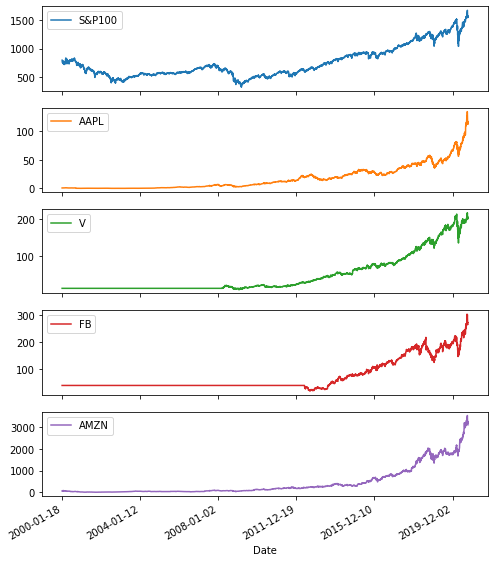

In [12]:
mpl.rcParams['figure.figsize'] = (8, 10)

tickers = ["S&P100", "AAPL", "V", "FB", "AMZN"]
features[tickers].plot(subplots=True);

In [14]:
features.shape

(5198, 102)

Стандартизируем (нормализуем) набор данных. Для расчета параметров стандартизации используем только **train**

In [17]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [18]:
dataset = (dataset-data_mean)/data_std

In [19]:
# dataset

Будем делать два варианта прогноза - точечное прогнозирование (одно значение, например - на следующий день) и интервальный прогноз (например - 10 дней вперед, с учетом выходных это будет две недели).    

Возможно, точечный прогноз будет иметь смысл заменить на классификацию **["buy", ""sell", "hold"]** (или просто ["buy", ""sell"]), иначе по **MSE** не вполне будет наглядно качество прогноза

## Точечное прогнозирование

In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Функция организации временных интервалов
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [21]:
past_history = 90  # смотрим историю за 90 дней (рабочих)
future_target = 1  # предсказываем следующий день
STEP = 1           # данные берем без пропусков

In [22]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, -1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, -1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Проверим временной интервал

In [23]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (90, 102)


In [24]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Построение модели

Модель будем строить с использованием рекурентных ячеек **LSTM**, сделаем их в несколько слоев, а также добавим одномерные свертки. 

In [25]:
class SP100ConvNet:

    def __init__(self, num_outputs, encoder_out_shape=32, features_num=102, dropout=0.0):
        self.encoder_out_shape = encoder_out_shape
        self.num_outputs = num_outputs
        self.features_num = features_num
        self.dropout = dropout
        self.model = None

    def encoder(self, inputs):
        x = layers.Conv1D(filters=512, kernel_size=5, padding='same', activation='relu')(inputs)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.LSTM(64, return_sequences=True, dropout=self.dropout)(x)
        x = layers.LayerNormalization()(x)
        x = layers.LSTM(64, activation='relu', dropout=self.dropout)(x)
        x = layers.LayerNormalization()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Dense(64)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Dense(self.encoder_out_shape)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.LayerNormalization()(x)
        return x

    def build_regress_branch(self, inputs, final_act="relu"):
        x = self.encoder(inputs)
        x = layers.Dense(self.num_outputs)(x)
        # x = layers.Activation(final_act, name="regress_output")(x)
        return x

    def build_class_branch(self, inputs, final_act="softmax"):
        x = self.encoder(inputs)
        x = layers.Dense(self.num_outputs)(x)
        x = layers.Activation(final_act, name="class_output")(x)
        return x

    def build(self):
        inputs = layers.Input(shape=(None, self.features_num))
        regress_branch = self.build_regress_branch(inputs)
#         class_branch = self.build_class_branch(inputs)
        self.model = Model(inputs=inputs,
                           outputs=regress_branch,
                           name="sp100net"
                           )
        return self.model

In [26]:
sp100net = SP100ConvNet(1)
single_step_model = sp100net.build()

In [27]:
single_step_model.summary()

Model: "sp100net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 102)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 512)         261632    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         655616    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0  

Проверим нашу выборку и модель на корректность

In [28]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


Из-за условно-бесконечного размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.

In [29]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [30]:
sp100net = SP100ConvNet(1, dropout=0.5)
single_step_model = sp100net.build()
single_step_model.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='mae')

In [31]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 24s 122ms/step - loss: 1.2957 - val_loss: 3.8974
Epoch 2/10
200/200 [==============================] - 24s 118ms/step - loss: 1.0599 - val_loss: 3.3699
Epoch 3/10
200/200 [==============================] - 23s 117ms/step - loss: 0.9597 - val_loss: 3.1972
Epoch 4/10
200/200 [==============================] - 24s 118ms/step - loss: 0.8870 - val_loss: 3.1073
Epoch 5/10
200/200 [==============================] - 24s 118ms/step - loss: 0.8465 - val_loss: 2.9066
Epoch 6/10
200/200 [==============================] - 24s 119ms/step - loss: 0.7966 - val_loss: 2.7890
Epoch 7/10
200/200 [==============================] - 24s 119ms/step - loss: 0.7634 - val_loss: 2.7381
Epoch 8/10
200/200 [==============================] - 24s 118ms/step - loss: 0.7353 - val_loss: 2.6688
Epoch 9/10
200/200 [==============================] - 24s 118ms/step - loss: 0.7087 - val_loss: 2.6602
Epoch 10/10
200/200 [==============================] - 24s 118ms/step - l

In [32]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

In [33]:
mpl.rcParams['figure.figsize'] = (8, 6)

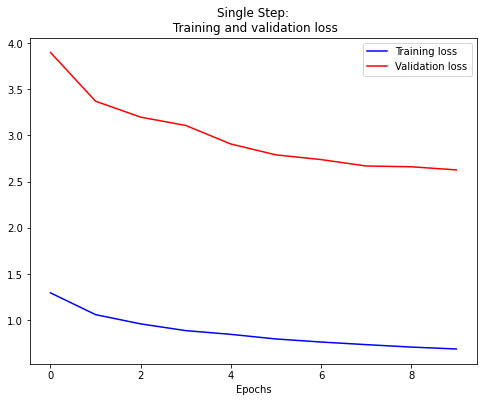

In [34]:
plot_train_history(single_step_history,
                   'Single Step:\n Training and validation loss')

In [35]:
def show_plot(plot_data, delta, title):
  def create_time_steps(length):
    return list(range(-length, 0))
    
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

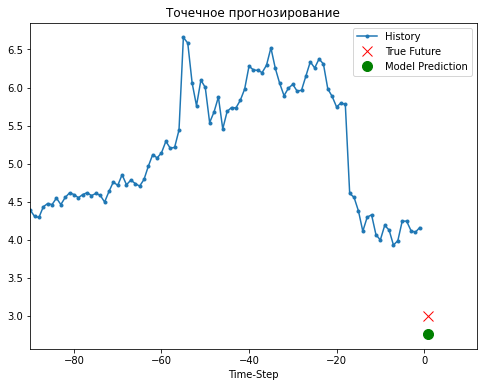

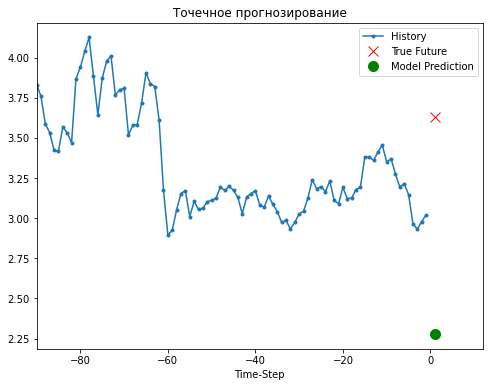

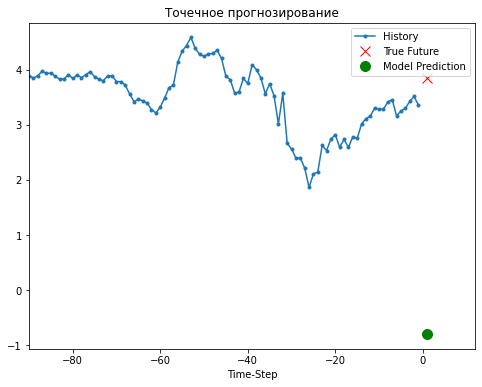

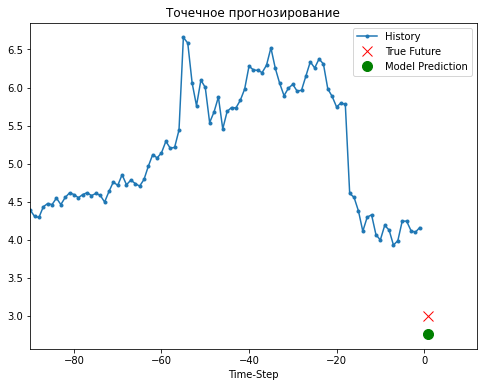

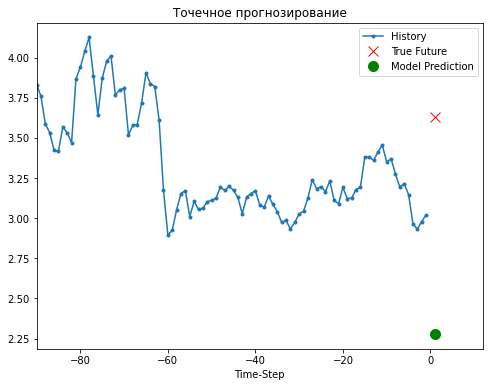

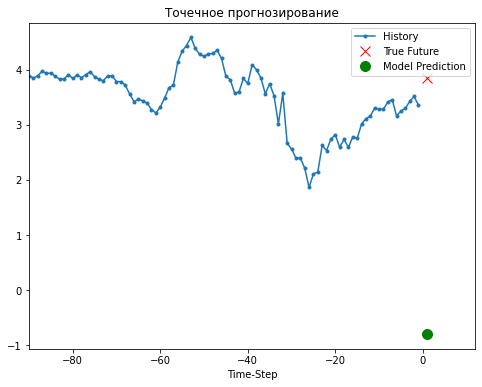

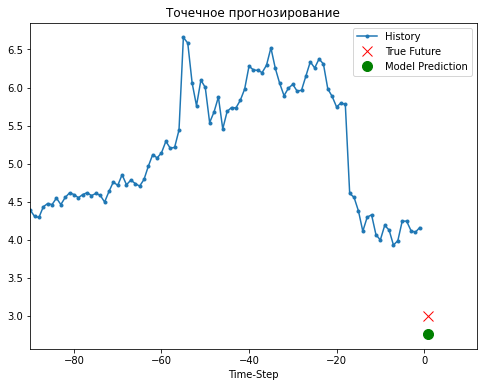

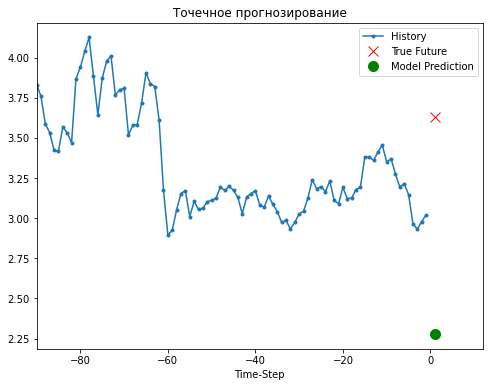

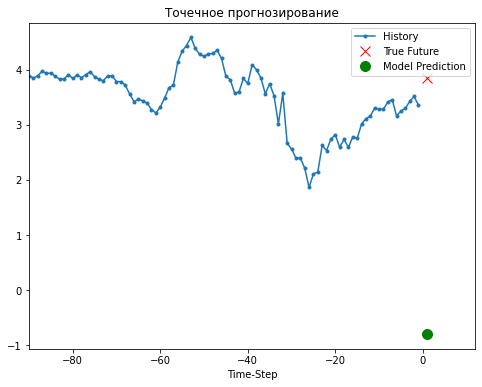

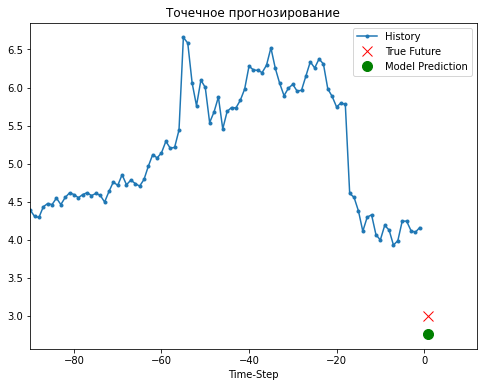

In [36]:
for x, y in val_data_single.take(10):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Точечное прогнозирование')
  plot.show()

## Интервальное прогнозирование
Прогнозирование интервала будущих значений

Будем прогнозировать на 10 дней вперед

In [37]:
future_target = 10  # число дней прогнозирований
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Проверим выборку

In [38]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target s&p100 to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (90, 102)

 Target s&p100 to predict : (10,)


In [39]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Подготовим визуализацию

In [40]:
def multi_step_plot(history, true_future, prediction):
  def create_time_steps(length):
    return list(range(-length, 0))
    
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

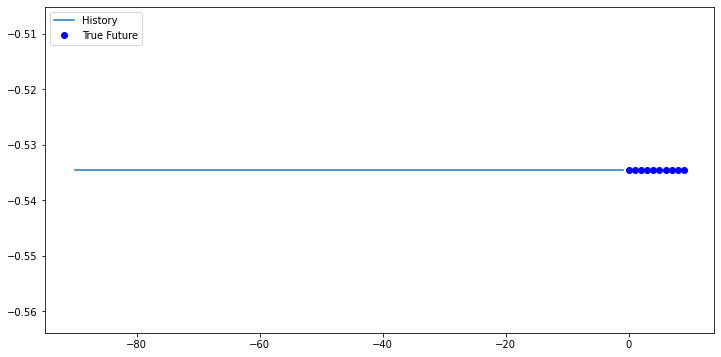

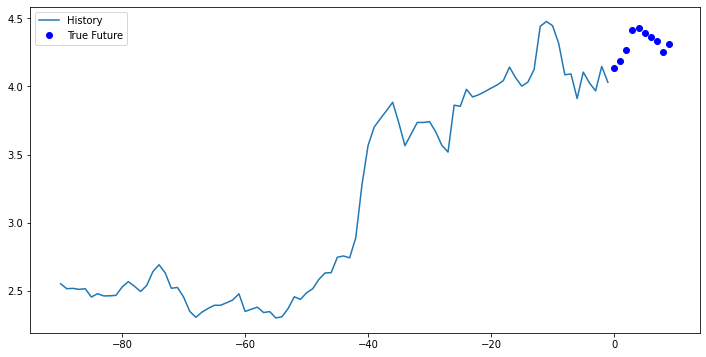

In [41]:
for x, y in train_data_multi.take(2):
  multi_step_plot(x[0], y[0], np.array([0]))

Строим модель

In [42]:
sp100net_multi = SP100ConvNet(10, dropout=0.5)
multi_step_model = sp100net_multi.build()
multi_step_model.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='mae')

Проверим нашу выборку 

In [43]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

(256, 10)


In [44]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 25s 124ms/step - loss: 1.0439 - val_loss: 3.2178
Epoch 2/10
200/200 [==============================] - 24s 119ms/step - loss: 0.9218 - val_loss: 3.0726
Epoch 3/10
200/200 [==============================] - 24s 119ms/step - loss: 0.8641 - val_loss: 3.0832
Epoch 4/10
200/200 [==============================] - 24s 118ms/step - loss: 0.8225 - val_loss: 3.1037
Epoch 5/10
200/200 [==============================] - 24s 120ms/step - loss: 0.7931 - val_loss: 3.1444
Epoch 6/10
200/200 [==============================] - 24s 119ms/step - loss: 0.7688 - val_loss: 3.1726
Epoch 7/10
200/200 [==============================] - 24s 118ms/step - loss: 0.7491 - val_loss: 3.1882
Epoch 8/10
200/200 [==============================] - 24s 118ms/step - loss: 0.7302 - val_loss: 3.1915
Epoch 9/10
200/200 [==============================] - 24s 118ms/step - loss: 0.7144 - val_loss: 3.1958
Epoch 10/10
200/200 [==============================] - 24s 118ms/step - l

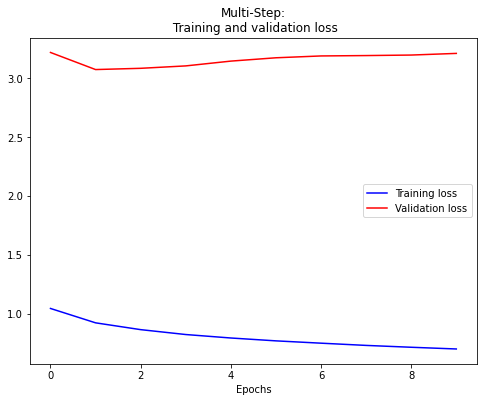

In [45]:
plot_train_history(multi_step_history, 'Multi-Step:\n Training and validation loss')

### Выполнение интервального прогноза

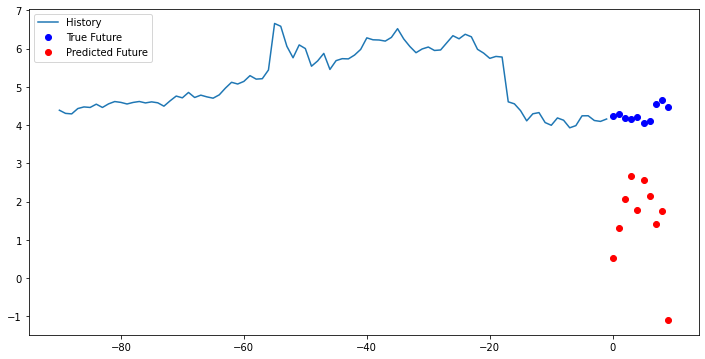

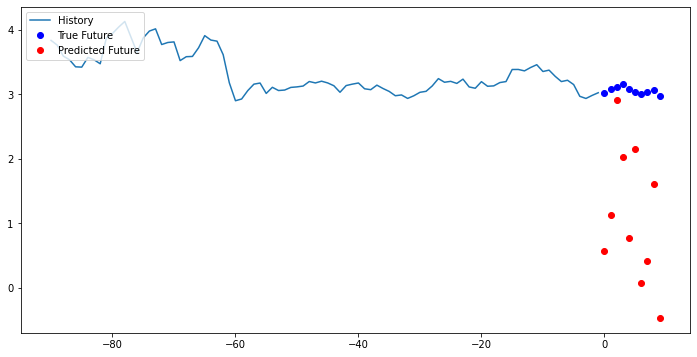

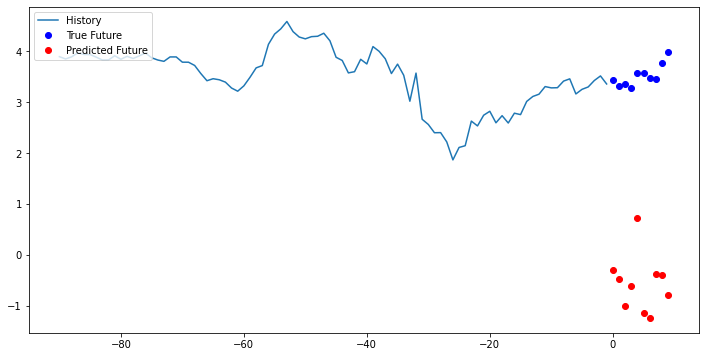

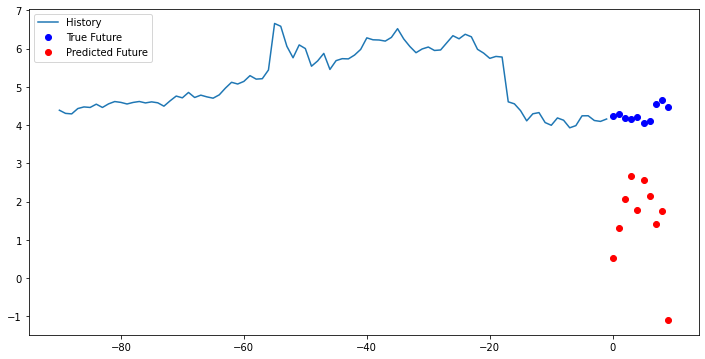

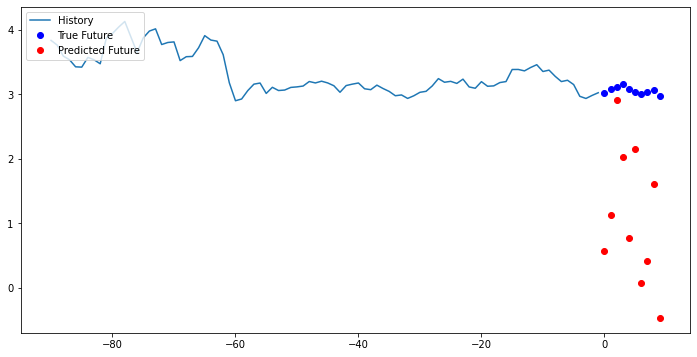

In [46]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])